# scAdam model train

In [1]:
# Python packages
import warnings
warnings.simplefilter('ignore')

import scanpy as sc
import scparadise
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

sc.set_figure_params(dpi = 120)

## Recommendations about training dataset 
We recommend shifted logarithm data normalization method: <br>
sc.pp.normalize_total(adata, target_sum=None) <br>
sc.pp.log1p(adata) <br>
But you can use any other method of data normalzation (Use the same normalization method for test dataset) <br>
Training dataset sould contain all genes that you want to use for model training in adata_train.X <br>
We recommend to remove all non-marker genes from adata_train.X (removeing of such useless genes increase performance and model quality metrics)

## Data preparation
Here we download and preprocess dataset from cellxgene: <br> 

Single cell RNA sequencing of oropharyngeal squamous cell carcinoma <br>
https://cellxgene.cziscience.com/collections/3c34e6f1-6827-47dd-8e19-9edcd461893f

In [2]:
!wget https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad

--2025-01-16 12:42:52--  https://datasets.cellxgene.cziscience.com/915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 52.85.49.125, 52.85.49.28, 52.85.49.24, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|52.85.49.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981941987 (936M) [binary/octet-stream]
Saving to: ‘915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad’

915069db-1df2-49a1- 100%[===================>] 936.45M  4.91MB/s    in 2m 16s  

2025-01-16 12:45:08 (6.89 MB/s) - ‘915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad’ saved [981941987/981941987]



In [3]:
# Load prepared for training anndata object
adata = sc.read_h5ad('915069db-1df2-49a1-9a9c-2fbd0aa13c81.h5ad')

In [4]:
# Get raw counts from adata.raw
adata = adata.raw.to_adata()

In [5]:
# Convert var_names from ENSG codes to gene names
adata.var.set_index('feature_name', inplace=True)
adata.var_names_make_unique()

In [6]:
# Create celltype_l1 and celltype_l2 annotation levels
adata.obs['celltype_l2'] = adata.obs['cell_type'].copy()
# Check current cluster name
cluster_list = adata.obs['celltype_l2'].unique()
# Make cluster anottation dictionary
annotation = {"epithelial":['epithelial cell'],
              "B":['B cell', 'plasma cell'],
              "T":['CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'mature alpha-beta T cell', 'regulatory T cell'],
              "NK":['natural killer cell'],
              "myeloid": ['myeloid cell', 'plasmacytoid dendritic cell', 'mast cell'],
              "endothelial":['endothelial cell', 'endothelial cell of lymphatic vessel'],
              "stromal": ['fibroblast', 'mural cell']}

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if i in annotation[k]:
            annotation_rev[i] = k

adata.obs["celltype_l1"] = [annotation_rev[i] for i in adata.obs['celltype_l2']]

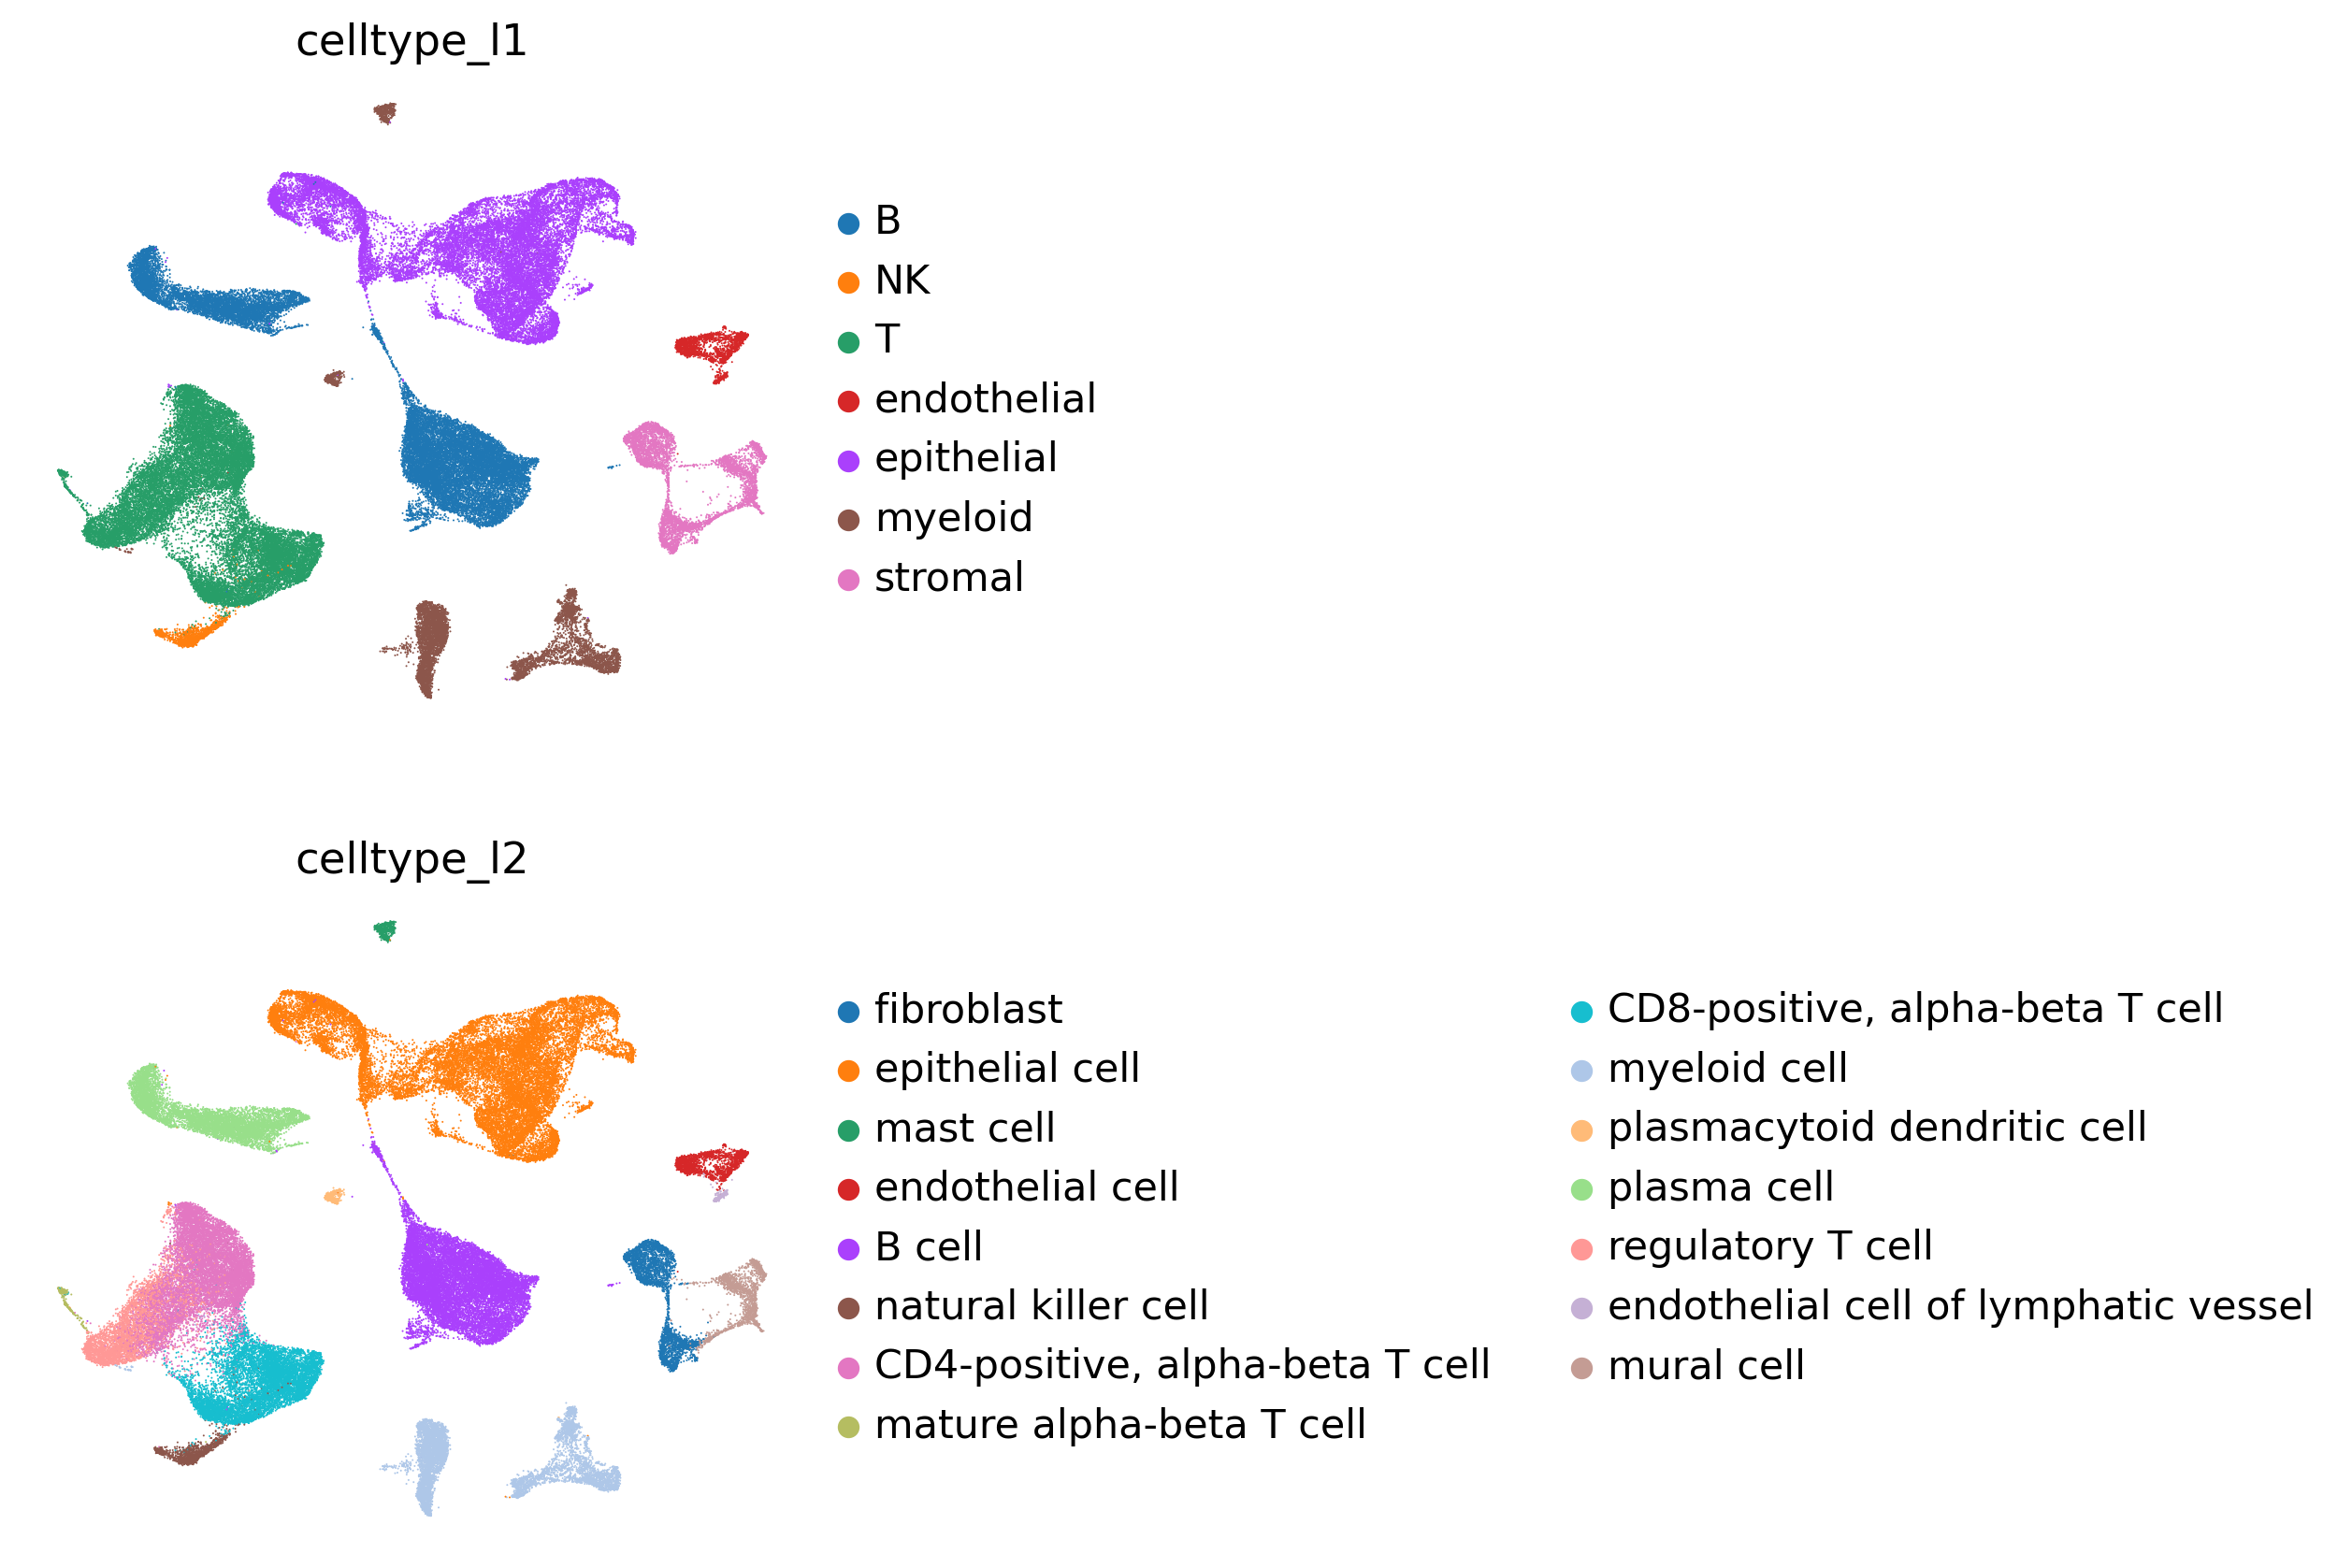

In [7]:
# Check annotations
sc.pl.embedding(adata,
                basis = 'X_umap',
                color = ['celltype_l1',
                         'celltype_l2'],
                frameon = False,
                ncols = 1)

In [8]:
# Create adata_train1, adata_train2 and adata_test datasets
adata_test = adata[adata.obs['donor_id'].isin(['HN481', 'HN482'])].copy()
adata_train = adata[adata.obs['donor_id'].isin(['HN483' 'HN485', 'HN488', 'HN489', 'HN490', 'HN487', 'HN492', 'HN494'])].copy()
del adata

In [9]:
# Normalize data, find highly variable features
for i in [adata_train, adata_test]:
    i.layers['counts'] = i.X.copy()
    sc.pp.normalize_total(i, target_sum=None)
    sc.pp.log1p(i)
    i.raw = i
    sc.pp.highly_variable_genes(i,
                                layer='counts',
                                flavor='seurat_v3',
                                n_top_genes=1200,
                                subset=True)

## Balanced training
We recommend balance dataset based on most detailed annotation level (celltype_l2 in this case). <br>
Balancing the training dataset increases the sensitivity (balanced accuracy), f1-score and geometric mean of the model but leads to slightly decrease in precision

In [10]:
# Balance dataset based on most detailed annotation level
adata_balanced = scparadise.scnoah.balance(adata_train, 
                                           sample = 'donor_id',
                                           celltype_l1 = 'celltype_l1',
                                           celltype_l2 = 'celltype_l2')

Successfully undersampled cell types: epithelial cell, B cell, myeloid cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, plasma cell

Successfully oversampled cell types: regulatory T cell, fibroblast, mural cell, endothelial cell, natural killer cell, plasmacytoid dendritic cell, mast cell, mature alpha-beta T cell, endothelial cell of lymphatic vessel


In [11]:
# Train scadam model using adata_balanced dataset
scparadise.scadam.train(adata_balanced,
                        path = '', # path to save model
                        model_name = 'model_scadam_balanced', # folder name with model
                        celltype_l1 = 'celltype_l1', # First (less detailed) annotation level
                        celltype_l2 = 'celltype_l2', # Second (most detailed) annotation level
                        eval_metric = ['balanced_accuracy','accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 44415 cells, it is 90.0 % of input dataset
Test dataset contains: 4935 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training
epoch 0  | loss: 2.21299 | train_balanced_accuracy: 0.49625 | train_accuracy: 0.55639 | valid_balanced_accuracy: 0.48656 | valid_accuracy: 0.5461  |  0:00:02s
epoch 1  | loss: 1.14552 | train_balanced_accuracy: 0.72033 | train_accuracy: 0.74447 | valid_balanced_accuracy: 0.70999 | valid_accuracy: 0.73587 |  0:00:05s
epoch 2  | loss: 0.74196 | train_balanced_accuracy: 0.84973 | train_accuracy: 0.8624  | valid_balanced_accuracy: 0.83588 | valid_accuracy: 0.84985 |  0:00:08s
epoch 3  | loss: 0.55414 | train_balanced_accuracy: 0.90071 | train_accuracy: 0.91104 | valid_balanced_accuracy: 0.89921 | valid_accuracy: 0.90942 |  0:00:11s
epoch 4  | loss: 0.46574 | train_balanced_accuracy: 0.92385 | train_accuracy: 0.93116 | valid

## Check model quality

In [13]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam_balanced')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully added predicted celltype_l2 and cell type probabilities


In [14]:
# Add prediction status to adata_test
scparadise.scnoah.pred_status(adata_test, 
                              celltype = 'celltype_l1',
                              pred_celltype = 'pred_celltype_l1',
                              key_added = 'pred_status_l1')
scparadise.scnoah.pred_status(adata_test, 
                              celltype = 'celltype_l2',
                              pred_celltype = 'pred_celltype_l2',
                              key_added = 'pred_status_l2')

In [15]:
# Order cell type colors
celltype_list = ['celltype_l1','celltype_l2']
for i in celltype_list:
    celltype = np.unique(adata_test.obs[i]).tolist()
    adata_test.obs[i] = pd.Categorical(
        values=adata_test.obs[i], categories=celltype, ordered=True
    )
    adata_test.obs['pred_' + i] = pd.Categorical(
        values=adata_test.obs['pred_' + i], categories=celltype, ordered=True
    )

1) The left column represents observed cell type annotations. <br>
2) The central column represents predicted cell type annotations. <br>
3) The right column represents prediction probabilities.

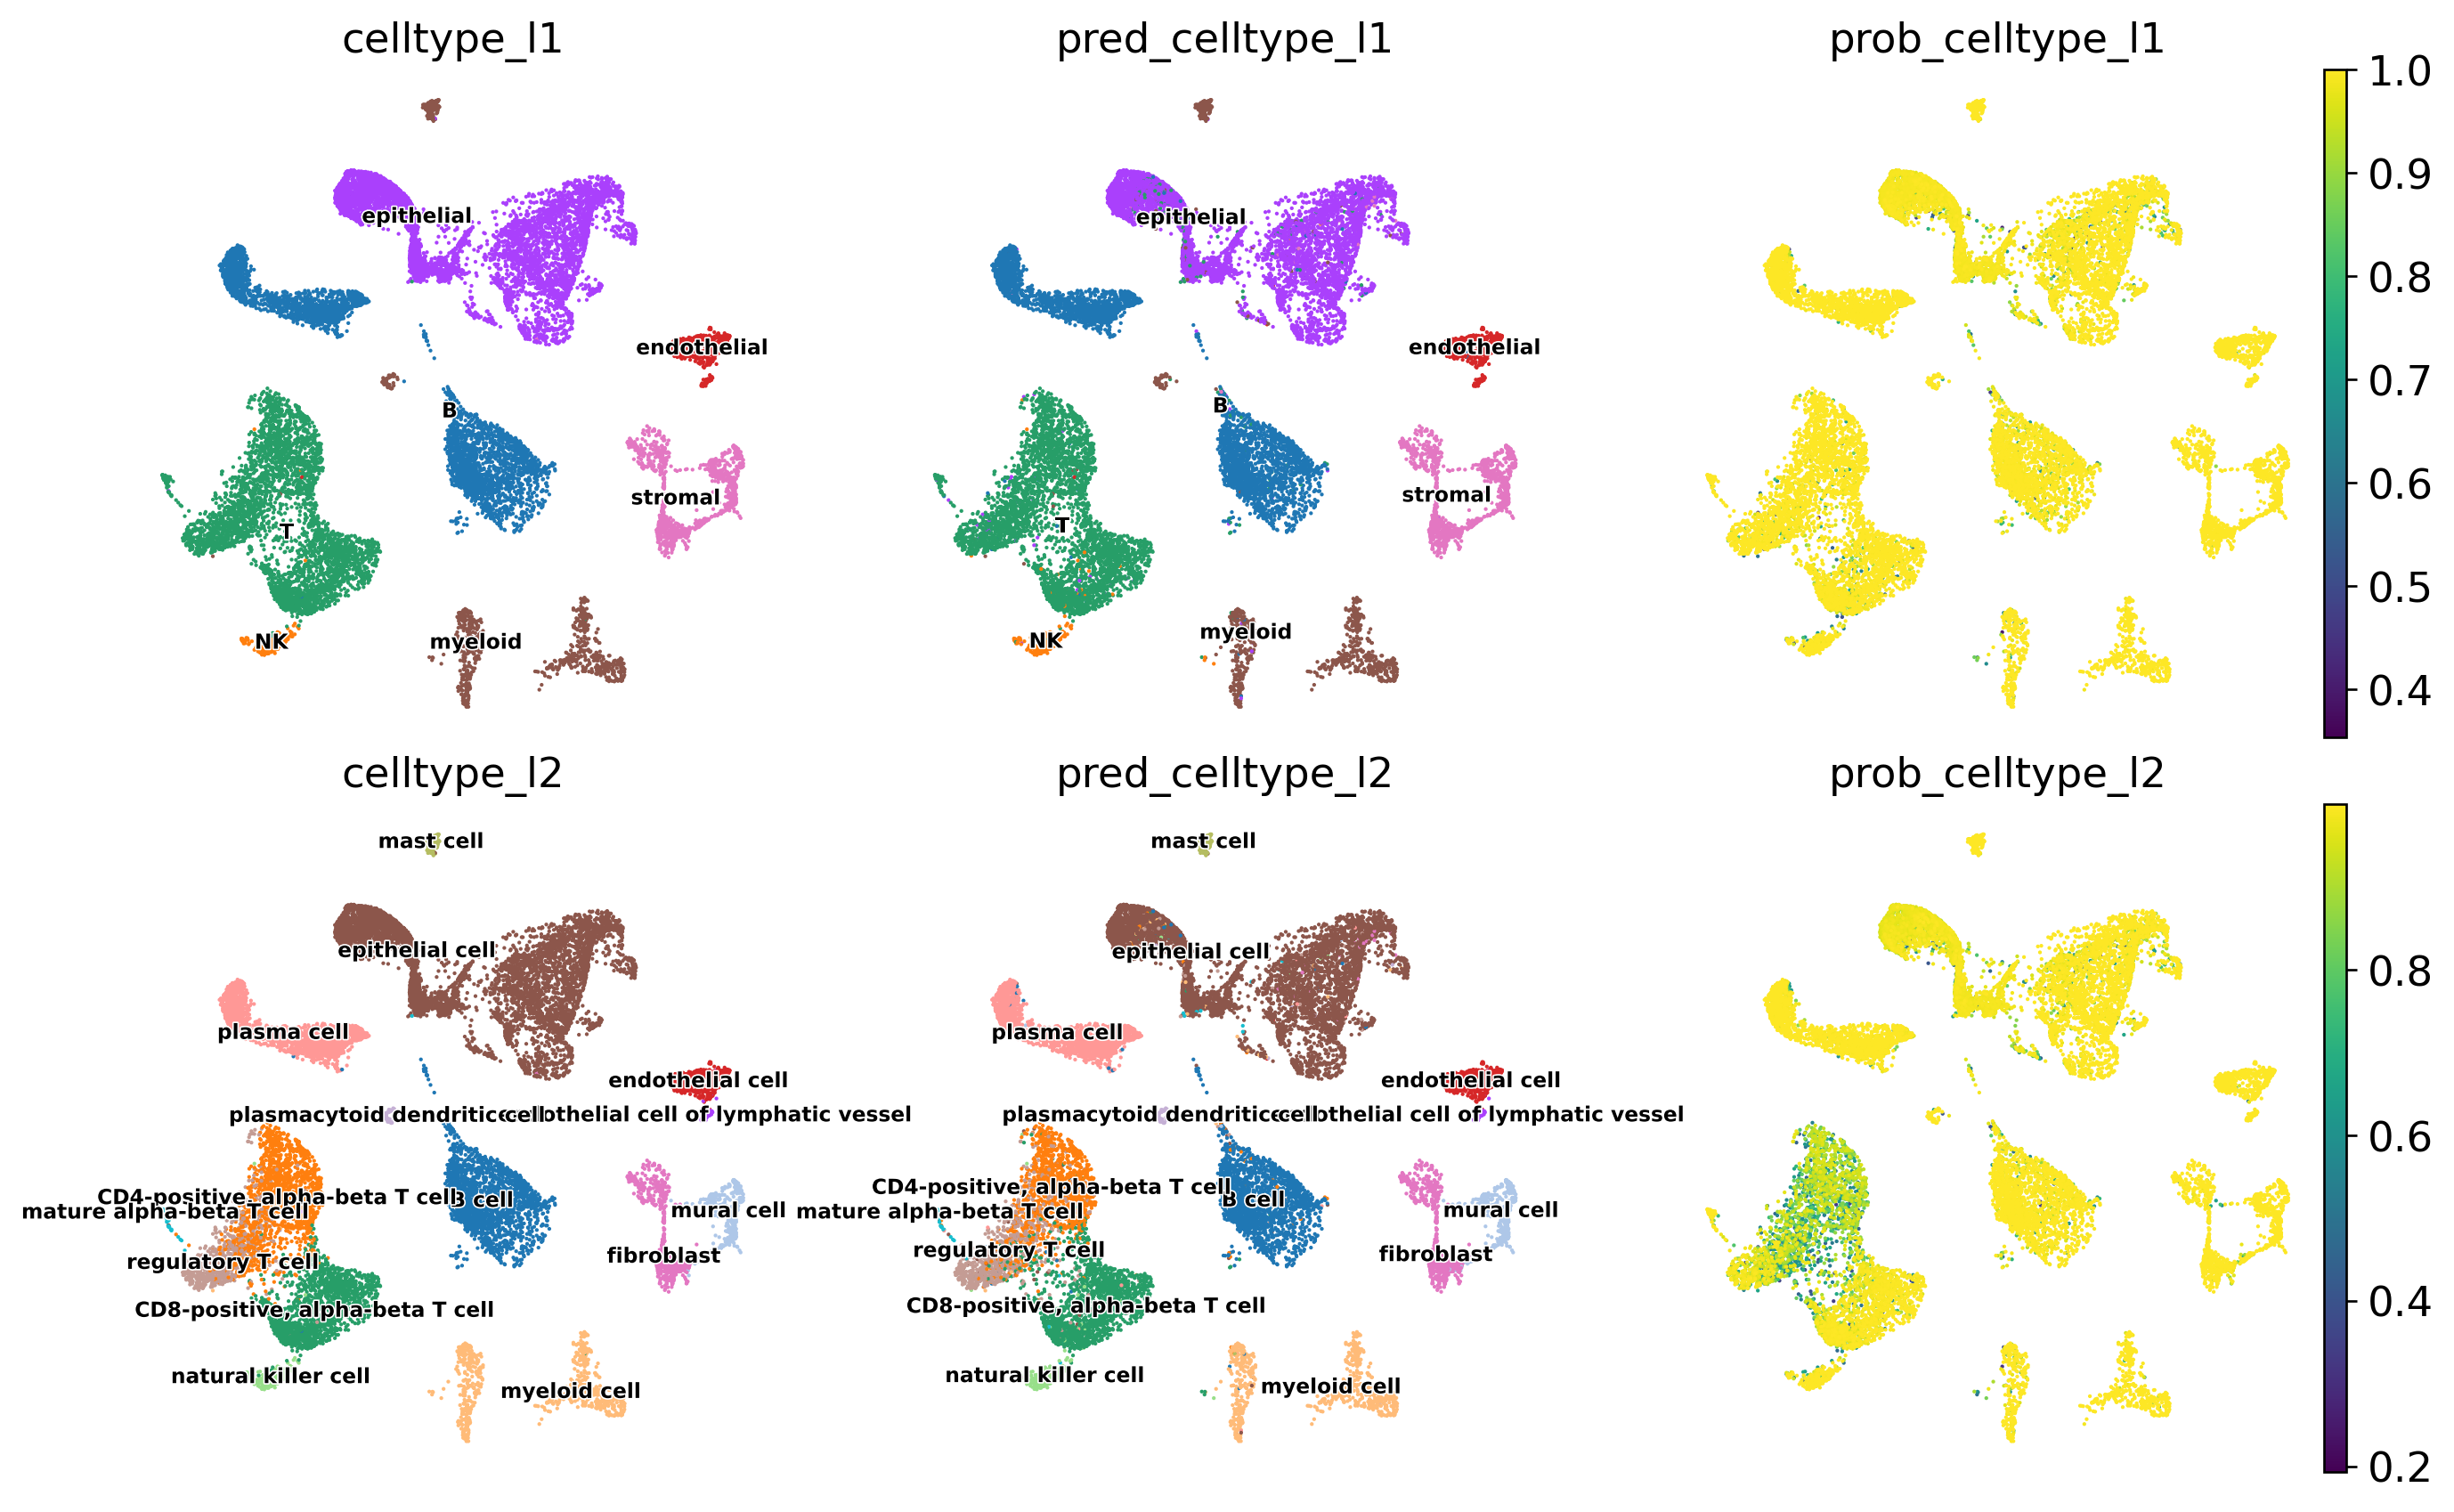

In [16]:
# Visualise predicted cell types levels and prediction probabilities
sc.pl.embedding(adata_test, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'celltype_l2',
                    'pred_celltype_l2',
                    'prob_celltype_l2'
                ],
                basis = 'X_umap',
                frameon = False,
                cmap = 'viridis',
                legend_loc = 'on data',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols = 3,
                wspace = 0.1, 
                hspace = 0.1)

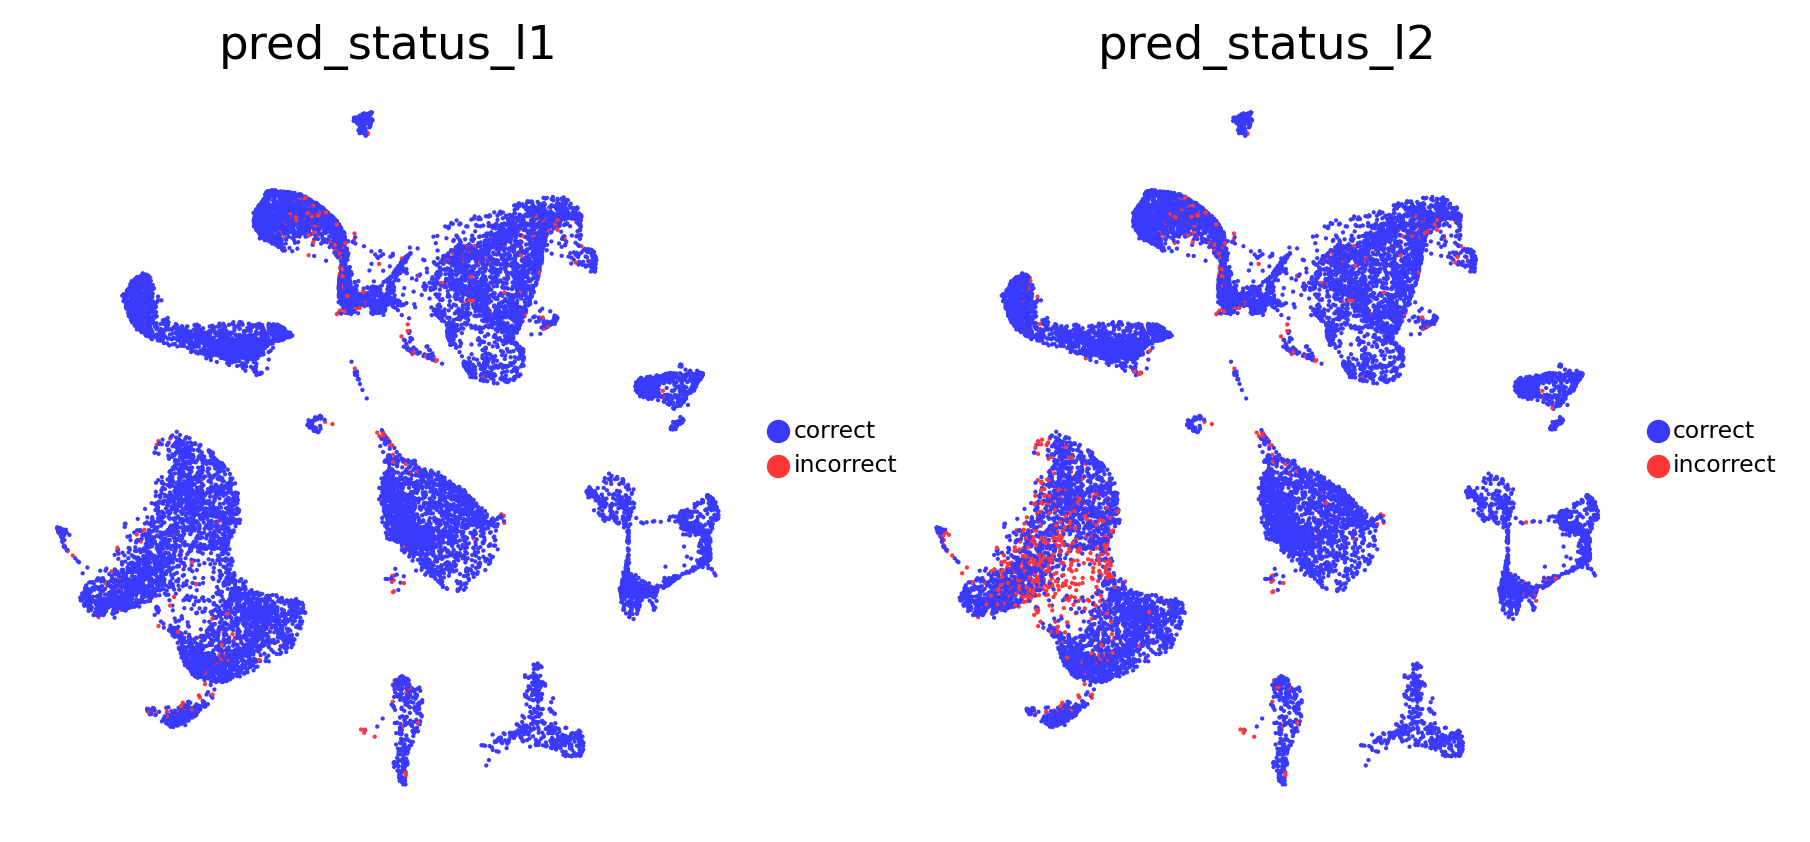

In [17]:
# Visualise prediction status
sc.pl.embedding(adata_test, 
                color=[
                    'pred_status_l1',
                    'pred_status_l2'
                ],
                basis = 'X_umap',
                frameon = False,
                cmap = 'viridis',
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols = 3,
                wspace = 0.1, 
                hspace = 0.1)

The probability and prediction status analysis indicates issues with the model in annotating T cell subtypes at the celltype_l2 annotation level. However, the model does not have problems with annotating other cell types, as confirmed by the quality analysis presented below.

### Comparizon of observed and predicted cell type annotations
To compare the actual and predicted cell types, we use `report_classif_full` and `conf_matrix` from the scNoah module. <br>
More information about the metrics in `scparadise.scnoah.report_classif_full` is available in the [scParadise documentation](https://scparadise.readthedocs.io/en/latest/theory.html#scnoah-metrics). <br>
More information about confusion matrix (`scparadise.scnoah.conf_matrix`) is available [here](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html).

In [18]:
# First annotation level (celltype_l1)
df_l1 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype = 'celltype_l1',
                                              pred_celltype = 'pred_celltype_l1',
                                              ndigits = 3)
df_l1

precision recall/sensitivity specificity f1-score  \
B                      0.982              0.984       0.995    0.983   
NK                     0.835              0.951       0.998    0.889   
T                      0.936              0.972       0.981    0.954   
endothelial            0.994              0.992         1.0    0.993   
epithelial             0.989              0.951       0.992     0.97   
myeloid                0.915              0.976       0.995    0.945   
stromal                0.971              0.997       0.998    0.984   
macro avg              0.946              0.975       0.994     0.96   
weighted avg           0.969              0.968       0.991    0.968   
Accuracy               0.968                                           
Balanced accuracy      0.975                                           

                  geometric mean index balanced accuracy number of cells  
B                          0.989                   0.978            3969  
NK                         0.974                   0.944             223  
T                          0.977                   0.953            4057  
endothelial                0.996                   0.991             509  
epithelial                 0.972                    0.94            7505  
myeloid                    0.986                    0.97             924  
stromal                    0.998                   0.995            1113  
macro avg                  0.984                   0.967                  
weighted avg                0.98                   0.958                  
Accuracy                                                                  
Balanced accuracy

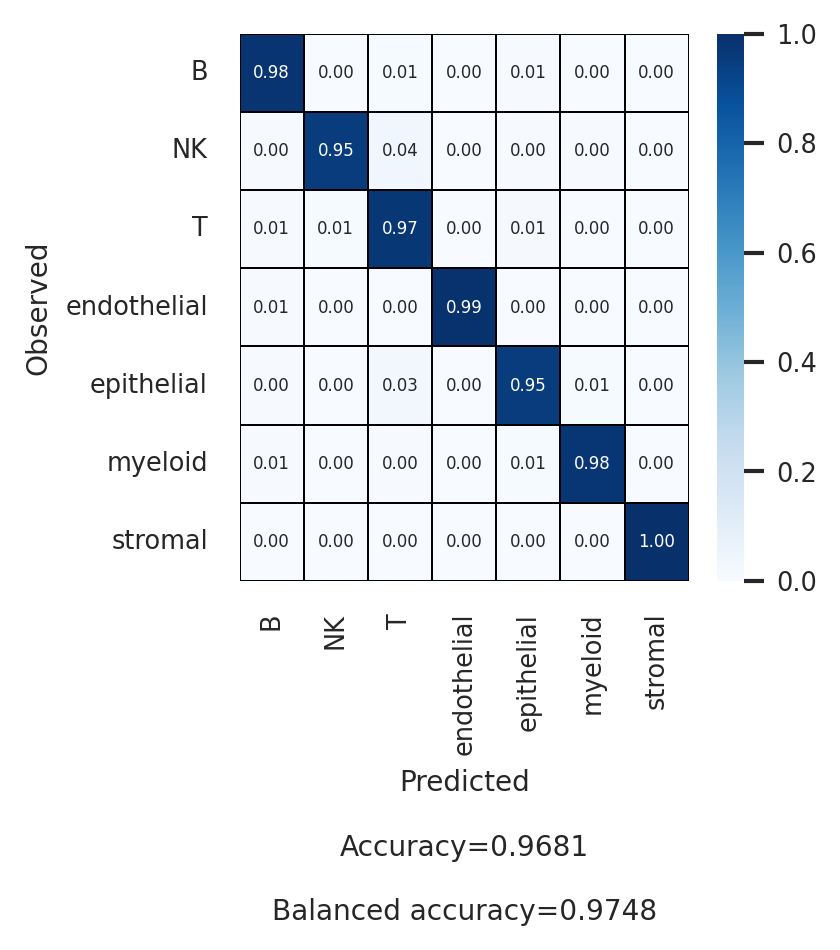

In [19]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (3, 3))
scparadise.scnoah.conf_matrix(adata_test,
                              celltype = 'celltype_l1',
                              pred_celltype = 'pred_celltype_l1',
                              annot_kws = {"size":5},
                              linewidths = 0.1, linecolor = 'black',
                              fmt =  ".2f",
                              ndigits_metrics = 4,
                              vmin = 0, vmax = 1)

In [20]:
# Second annotation level (celltype_l2)
df_l2 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype = 'celltype_l2',
                                              pred_celltype = 'pred_celltype_l2',
                                              ndigits = 3)
df_l2

precision recall/sensitivity  \
B cell                                    0.965              0.969   
CD4-positive, alpha-beta T cell           0.892              0.719   
CD8-positive, alpha-beta T cell           0.886              0.943   
endothelial cell                          0.989              0.991   
endothelial cell of lymphatic vessel      1.000              0.981   
epithelial cell                           0.989              0.954   
fibroblast                                0.928              0.979   
mast cell                                 0.986               0.98   
mature alpha-beta T cell                  0.629               0.88   
mural cell                                0.968              0.973   
myeloid cell                              0.890              0.971   
natural killer cell                       0.839              0.955   
plasma cell                               0.983              0.988   
plasmacytoid dendritic cell               0.875               0.98   
regulatory T cell                         0.596              0.824   
macro avg                                 0.894              0.939   
weighted avg                              0.943              0.937   
Accuracy                                  0.937                      
Balanced accuracy                         0.939                      

                                     specificity f1-score geometric mean  \
B cell                                     0.996    0.967          0.982   
CD4-positive, alpha-beta T cell            0.992    0.796          0.845   
CD8-positive, alpha-beta T cell            0.987    0.914          0.965   
endothelial cell                             1.0     0.99          0.995   
endothelial cell of lymphatic vessel         1.0     0.99           0.99   
epithelial cell                            0.993    0.971          0.973   
fibroblast                                 0.997    0.953          0.988   
mast cell                                    1.0    0.983           0.99   
mature alpha-beta T cell                   0.998    0.733          0.937   
mural cell                                 0.999     0.97          0.986   
myeloid cell                               0.995    0.929          0.983   
natural killer cell                        0.998    0.893          0.976   
plasma cell                                0.998    0.985          0.993   
plasmacytoid dendritic cell                  1.0    0.925           0.99   
regulatory T cell                          0.978    0.692          0.898   
macro avg                                  0.995    0.913          0.966   
weighted avg                               0.993    0.938          0.964   
Accuracy                                                                   
Balanced accuracy                                                          

                                     index balanced accuracy number of cells  
B cell                                                 0.962            2050  
CD4-positive, alpha-beta T cell                        0.694            1554  
CD8-positive, alpha-beta T cell                        0.927            1742  
endothelial cell                                        0.99             457  
endothelial cell of lymphatic vessel                   0.979              52  
epithelial cell                                        0.944            7505  
fibroblast                                             0.975             676  
mast cell                                              0.978             148  
mature alpha-beta T cell                               0.868              75  
mural cell                                             0.969             437  
myeloid cell                                           0.964             726  
natural killer cell                                    0.949             223  
plasma cell                                            0.985            1919  
plasmacyto

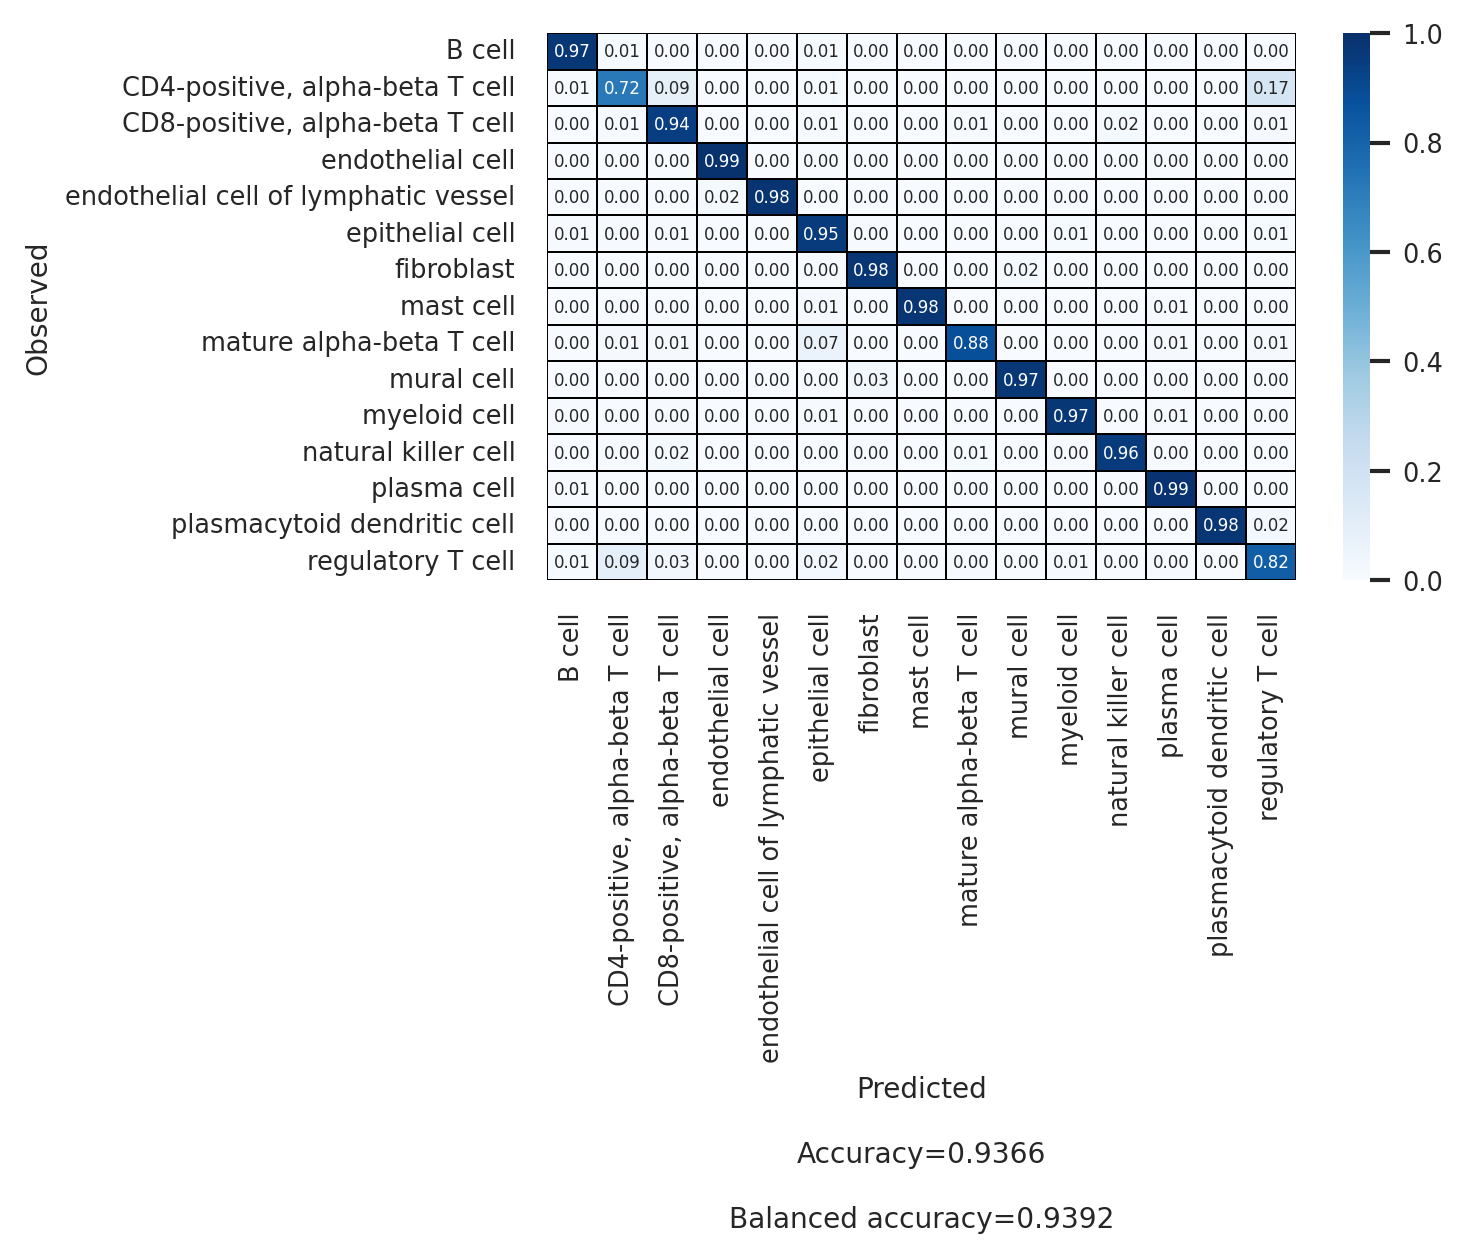

In [21]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (5, 3))
scparadise.scnoah.conf_matrix(adata_test,
                              celltype = 'celltype_l2',
                              pred_celltype = 'pred_celltype_l2',
                              annot_kws = {"size":5},
                              linewidths = 0.1, linecolor = 'black',
                              fmt =  ".2f",
                              ndigits_metrics = 4,
                              vmin = 0, vmax = 1)

In [22]:
# Save anndata with predicted annotations
adata_test.write_h5ad('adata_test_balanced_model.h5ad')

## Imbalanced training
Use 'balanced_accuracy' as evaluation metric in case of imbalanced learning

In [23]:
# Train scadam model using adata_balanced dataset
scparadise.scadam.train(adata_train,
                        path = '', # path to save model
                        model_name = 'model_scadam_imbalanced', # folder name with model
                        celltype_l1 = 'celltype_l1', # First (less detailed) annotation level
                        celltype_l2 = 'celltype_l2', # Second (most detailed) annotation level
                        eval_metric = ['accuracy','balanced_accuracy']) # If you are using an imbalanced training dataset, we recommend using balance_accuracy for early stopping

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 44414 cells, it is 90.0 % of input dataset
Test dataset contains: 4935 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training
epoch 0  | loss: 1.89983 | train_accuracy: 0.6205  | train_balanced_accuracy: 0.34227 | valid_accuracy: 0.6157  | valid_balanced_accuracy: 0.33701 |  0:00:02s
epoch 1  | loss: 0.93062 | train_accuracy: 0.76397 | train_balanced_accuracy: 0.5379  | valid_accuracy: 0.7613  | valid_balanced_accuracy: 0.54393 |  0:00:05s
epoch 2  | loss: 0.63447 | train_accuracy: 0.89784 | train_balanced_accuracy: 0.6967  | valid_accuracy: 0.89656 | valid_balanced_accuracy: 0.6991  |  0:00:08s
epoch 3  | loss: 0.45799 | train_accuracy: 0.92658 | train_balanced_accuracy: 0.79117 | valid_accuracy: 0.92533 | valid_balanced_accuracy: 0.7936  |  0:00:11s
epoch 4  | loss: 0.38553 | train_accuracy: 0.93557 | train_balanced_accuracy: 0.82882 | valid

## Check model quality

In [24]:
# Predict cell types using trained model
adata_test = scparadise.scadam.predict(adata_test, 
                                       path_model = 'model_scadam_imbalanced')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully added predicted celltype_l2 and cell type probabilities


In [25]:
# Add prediction status to adata_test
scparadise.scnoah.pred_status(adata_test, 
                              celltype = 'celltype_l1',
                              pred_celltype = 'pred_celltype_l1',
                              key_added = 'pred_status_l1')
scparadise.scnoah.pred_status(adata_test, 
                              celltype = 'celltype_l2',
                              pred_celltype = 'pred_celltype_l2',
                              key_added = 'pred_status_l2')

In [26]:
# Order cell type colors
celltype_list = ['celltype_l1','celltype_l2']
for i in celltype_list:
    celltype = np.unique(adata_test.obs[i]).tolist()
    adata_test.obs[i] = pd.Categorical(
        values=adata_test.obs[i], categories=celltype, ordered=True
    )
    adata_test.obs['pred_' + i] = pd.Categorical(
        values=adata_test.obs['pred_' + i], categories=celltype, ordered=True
    )

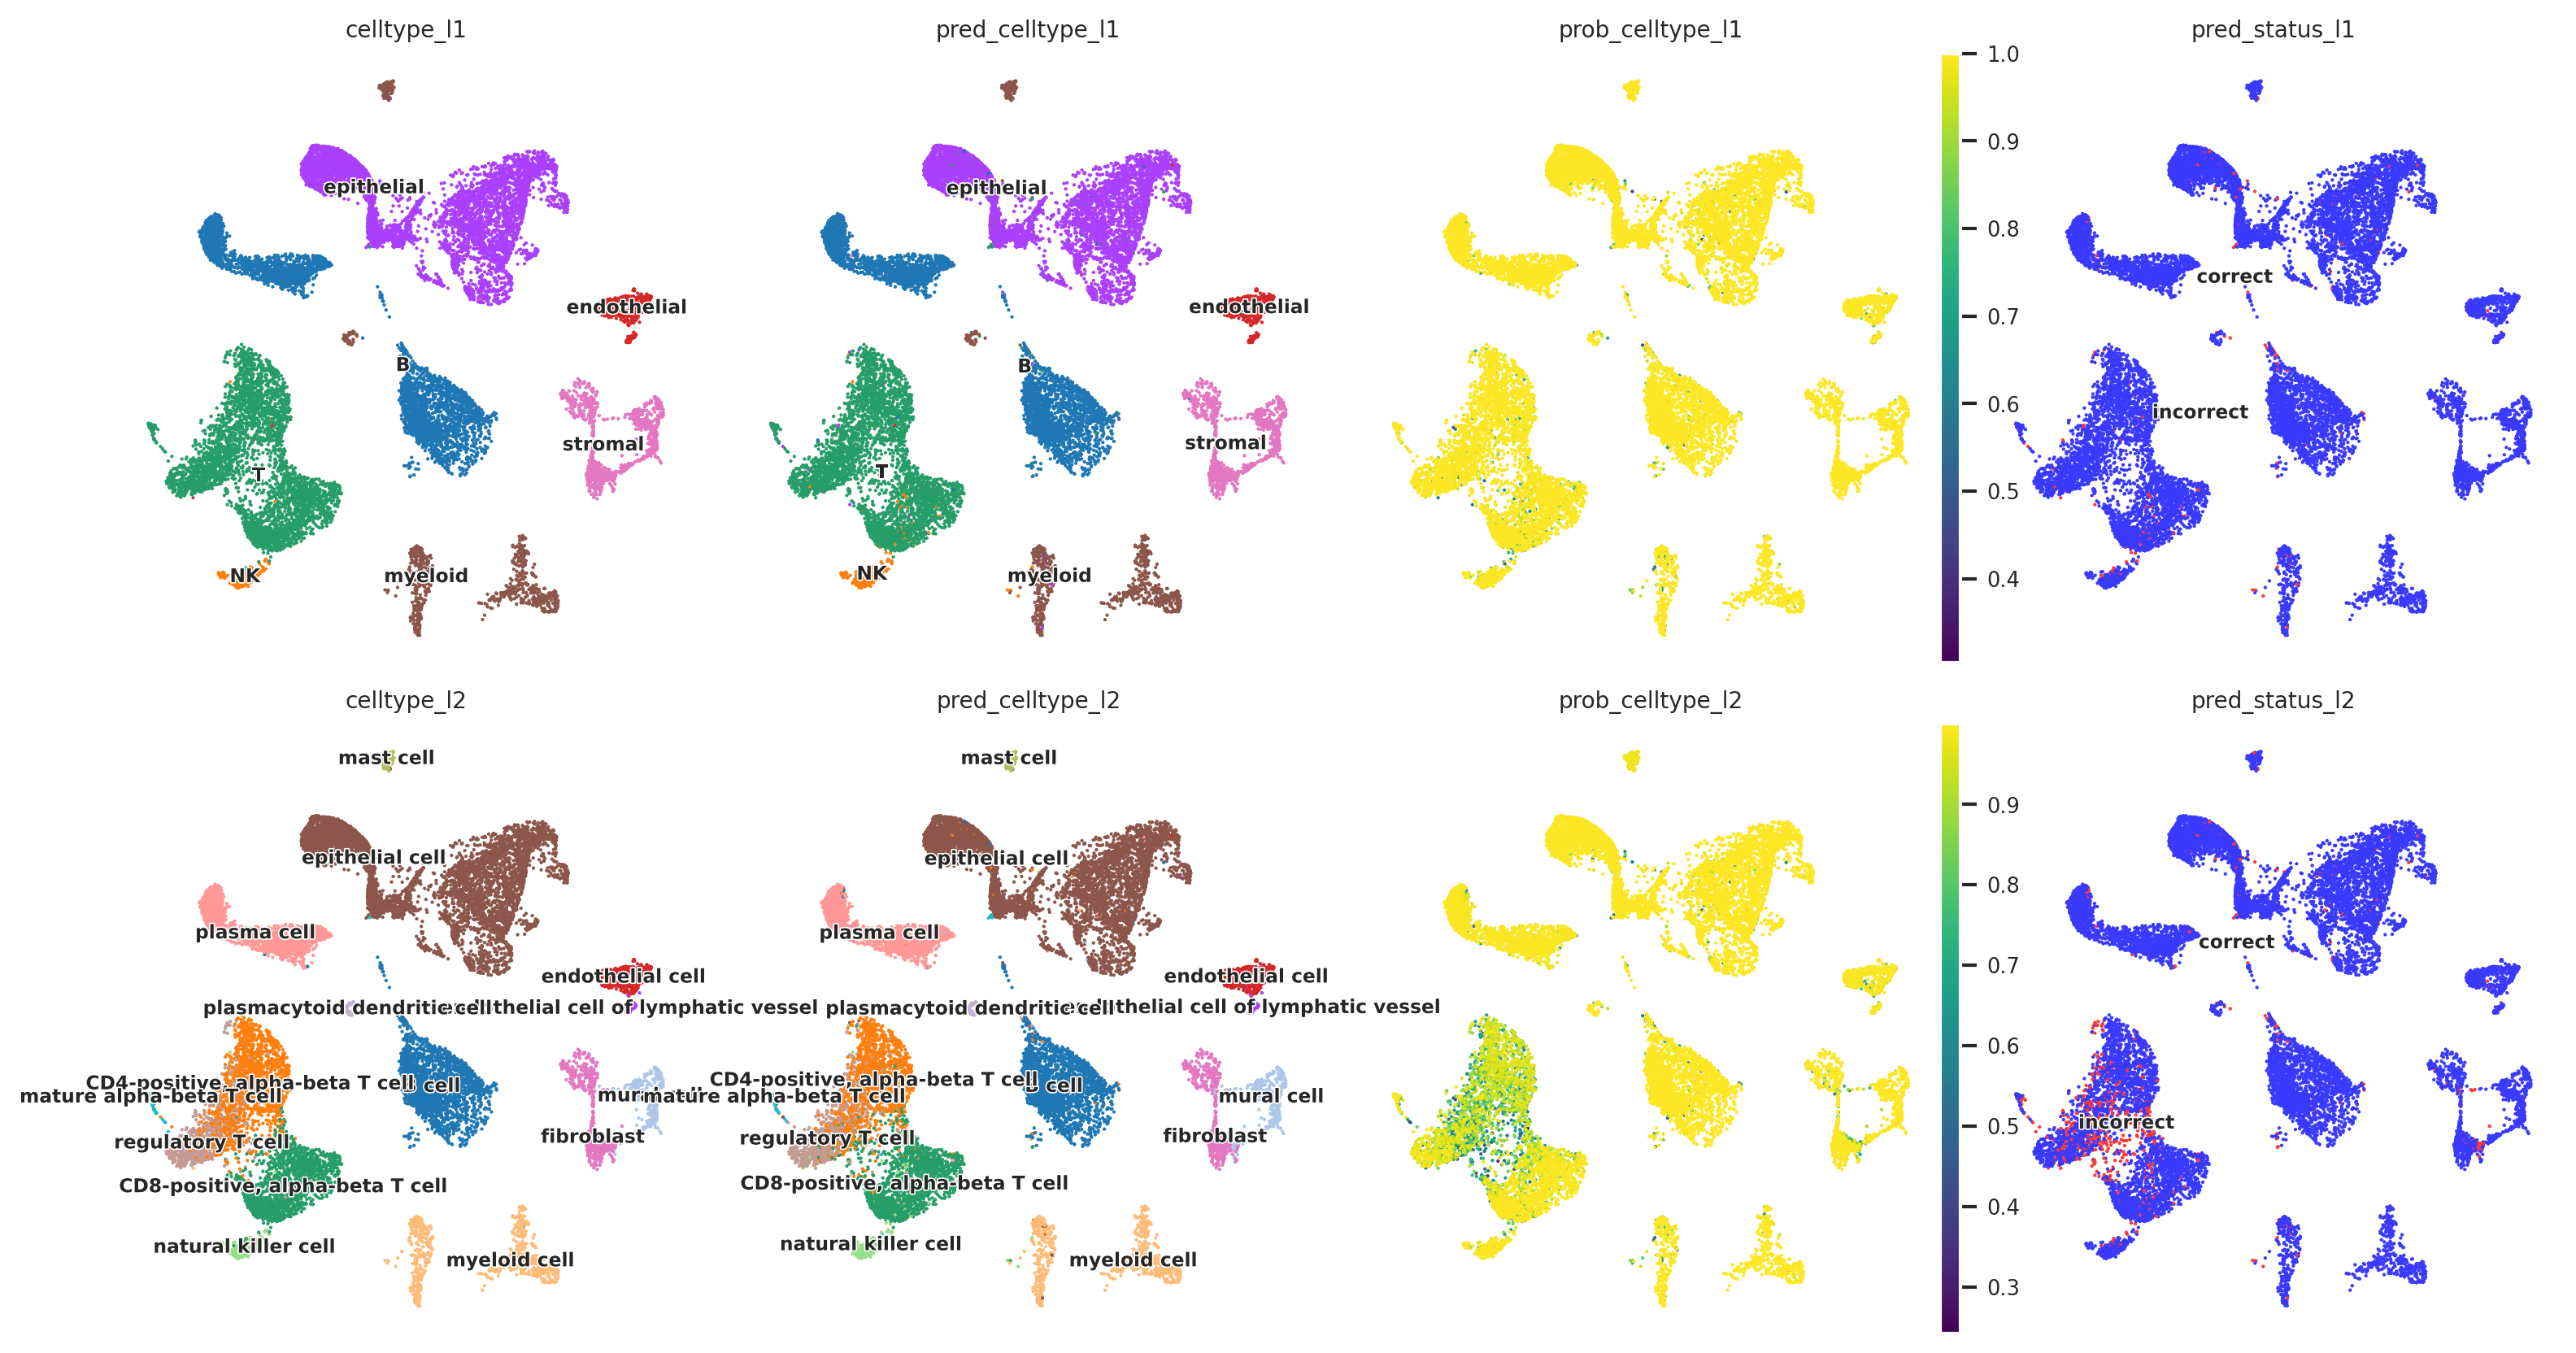

In [27]:
# Visualise predicted cell types levels and prediction probabilities
sc.pl.embedding(adata_test, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status_l1',
                    'celltype_l2',
                    'pred_celltype_l2',
                    'prob_celltype_l2',
                    'pred_status_l2'
                ],
                basis = 'X_umap',
                frameon = False,
                cmap = 'viridis',
                legend_loc = 'on data',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols = 4,
                wspace = 0, 
                hspace = 0.1)

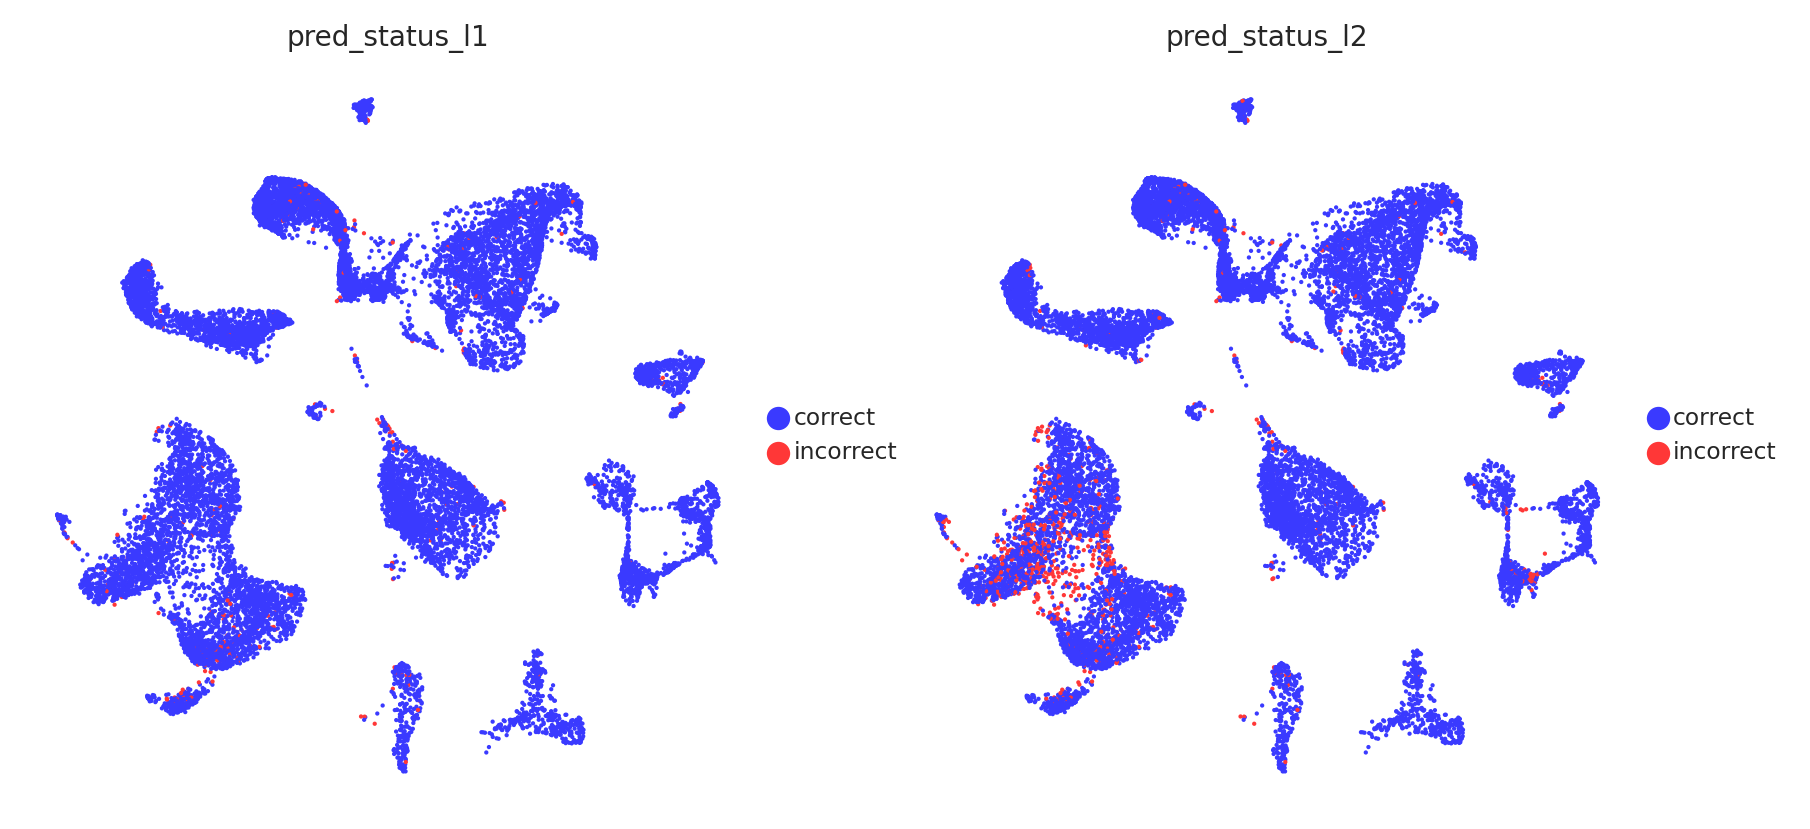

In [28]:
# Visualise prediction status
sc.pl.embedding(adata_test, 
                color=[
                    'pred_status_l1',
                    'pred_status_l2'
                ],
                basis = 'X_umap',
                frameon = False,
                cmap = 'viridis',
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols = 3,
                wspace = 0.1, 
                hspace = 0.1)

The probability and prediction status analysis indicates issues with the model in annotating T cell subtypes at the celltype_l2 annotation level. However, the model does not have problems with annotating other cell types, as confirmed by the quality analysis presented below.

### Comparizon of observed and predicted cell type annotations
To compare the actual and predicted cell types, we use `report_classif_full` and `conf_matrix` from the scNoah module. <br>
More information about the metrics in `scparadise.scnoah.report_classif_full` is available in the [scParadise documentation](https://scparadise.readthedocs.io/en/latest/theory.html#scnoah-metrics). <br>
More information about confusion matrix (`scparadise.scnoah.conf_matrix`) is available [here](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html).

In [29]:
# First annotation level (celltype_l1)
df_l1 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l1',
                                              pred_celltype='pred_celltype_l1')
df_l1

precision recall/sensitivity specificity f1-score  \
B                     0.9881             0.9829      0.9967   0.9855   
NK                    0.7220             0.9552      0.9955   0.8224   
T                     0.9732             0.9675      0.9924   0.9703   
endothelial           0.9980             0.9784      0.9999   0.9881   
epithelial            0.9888             0.9859      0.9922   0.9873   
myeloid               0.9825             0.9697      0.9991    0.976   
stromal               0.9832             0.9982      0.9989   0.9906   
macro avg             0.9480             0.9768      0.9964     0.96   
weighted avg          0.9815             0.9805      0.9942   0.9808   
Accuracy              0.9805                                           
Balanced accuracy     0.9768                                           

                  geometric mean index balanced accuracy number of cells  
B                         0.9898                  0.9783            3969  
NK                        0.9751                   0.947             223  
T                         0.9799                  0.9577            4057  
endothelial               0.9891                  0.9762             509  
epithelial                 0.989                  0.9776            7505  
myeloid                   0.9843                   0.966             924  
stromal                   0.9985                   0.997            1113  
macro avg                 0.9865                  0.9714                  
weighted avg              0.9873                  0.9735                  
Accuracy                                                                  
Balanced accuracy

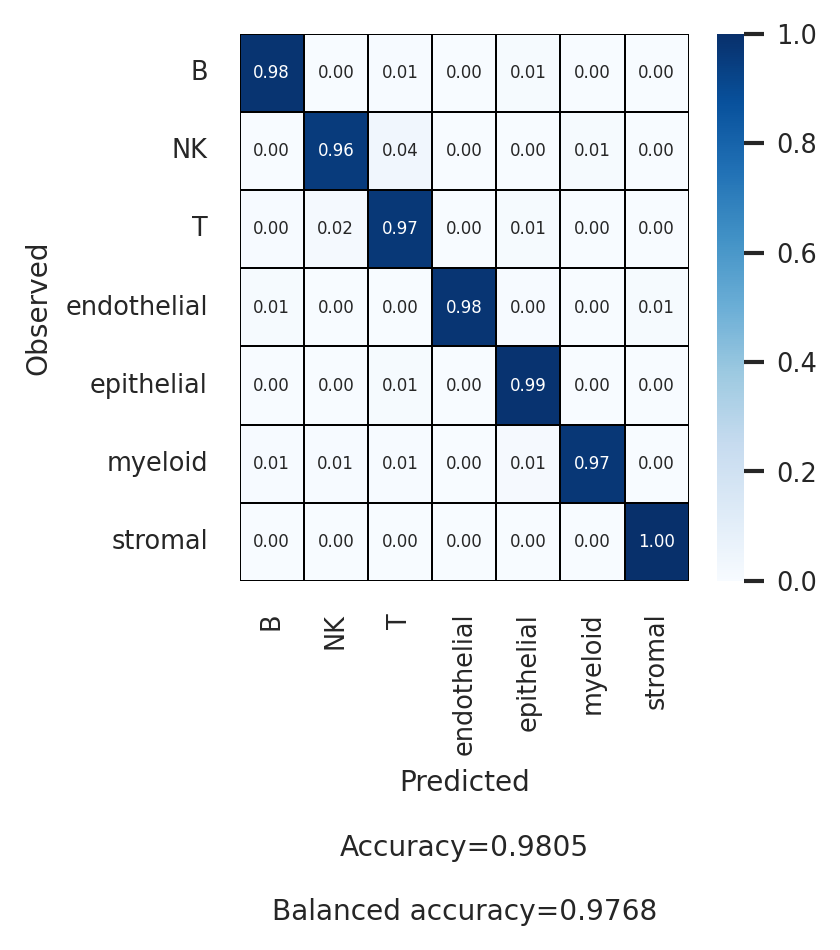

In [30]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (3, 3))
scparadise.scnoah.conf_matrix(adata_test,
                              celltype = 'celltype_l1',
                              pred_celltype = 'pred_celltype_l1',
                              annot_kws = {"size":5},
                              linewidths = 0.1, linecolor = 'black',
                              fmt =  ".2f",
                              ndigits_metrics = 4,
                              vmin = 0, vmax = 1)

In [31]:
# Second annotation level (celltype_l2)
df_l2 = scparadise.scnoah.report_classif_full(adata_test,
                                              celltype='celltype_l2',
                                              pred_celltype='pred_celltype_l2')
df_l2

precision recall/sensitivity  \
B cell                                   0.9819             0.9766   
CD4-positive, alpha-beta T cell          0.8686             0.8166   
CD8-positive, alpha-beta T cell          0.9166             0.9208   
endothelial cell                         0.9956             0.9847   
endothelial cell of lymphatic vessel     0.9273             0.9808   
epithelial cell                          0.9884              0.986   
fibroblast                               0.9844             0.9364   
mast cell                                0.9728             0.9662   
mature alpha-beta T cell                 0.7901             0.8533   
mural cell                               0.8979             0.9863   
myeloid cell                             0.9777             0.9656   
natural killer cell                      0.7245             0.9552   
plasma cell                              0.9854             0.9859   
plasmacytoid dendritic cell              0.8704               0.94   
regulatory T cell                        0.7528             0.7901   
macro avg                                0.9090             0.9363   
weighted avg                             0.9543             0.9531   
Accuracy                                 0.9531                      
Balanced accuracy                        0.9363                      

                                     specificity f1-score geometric mean  \
B cell                                    0.9977   0.9792         0.9871   
CD4-positive, alpha-beta T cell           0.9885   0.8418         0.8985   
CD8-positive, alpha-beta T cell           0.9912   0.9187         0.9553   
endothelial cell                          0.9999   0.9901         0.9923   
endothelial cell of lymphatic vessel      0.9998   0.9533         0.9902   
epithelial cell                           0.9919   0.9872          0.989   
fibroblast                                0.9994   0.9598         0.9674   
mast cell                                 0.9998   0.9695         0.9829   
mature alpha-beta T cell                  0.9991   0.8205         0.9233   
mural cell                                0.9973     0.94         0.9917   
myeloid cell                              0.9991   0.9716         0.9822   
natural killer cell                       0.9955    0.824         0.9751   
plasma cell                               0.9983   0.9857         0.9921   
plasmacytoid dendritic cell               0.9996   0.9038         0.9694   
regulatory T cell                         0.9899    0.771         0.8844   
macro avg                                 0.9965   0.9211         0.9654   
weighted avg                              0.9939   0.9533         0.9728   
Accuracy                                                                   
Balanced accuracy                                                          

                                     index balanced accuracy number of cells  
B cell                                                0.9723            2050  
CD4-positive, alpha-beta T cell                       0.7934            1554  
CD8-positive, alpha-beta T cell                       0.9062            1742  
endothelial cell                                      0.9831             457  
endothelial cell of lymphatic vessel                  0.9787              52  
epithelial cell                                       0.9775            7505  
fibroblast                                              0.93             676  
mast cell                                             0.9628             148  
mature alpha-beta T cell                              0.8401              75  
mural cell                                            0.9825             437  
myeloid cell                                          0.9615             726  
natural killer cell                                    0.947             223  
plasma cell                                            0.983            1919  
plasmacyto

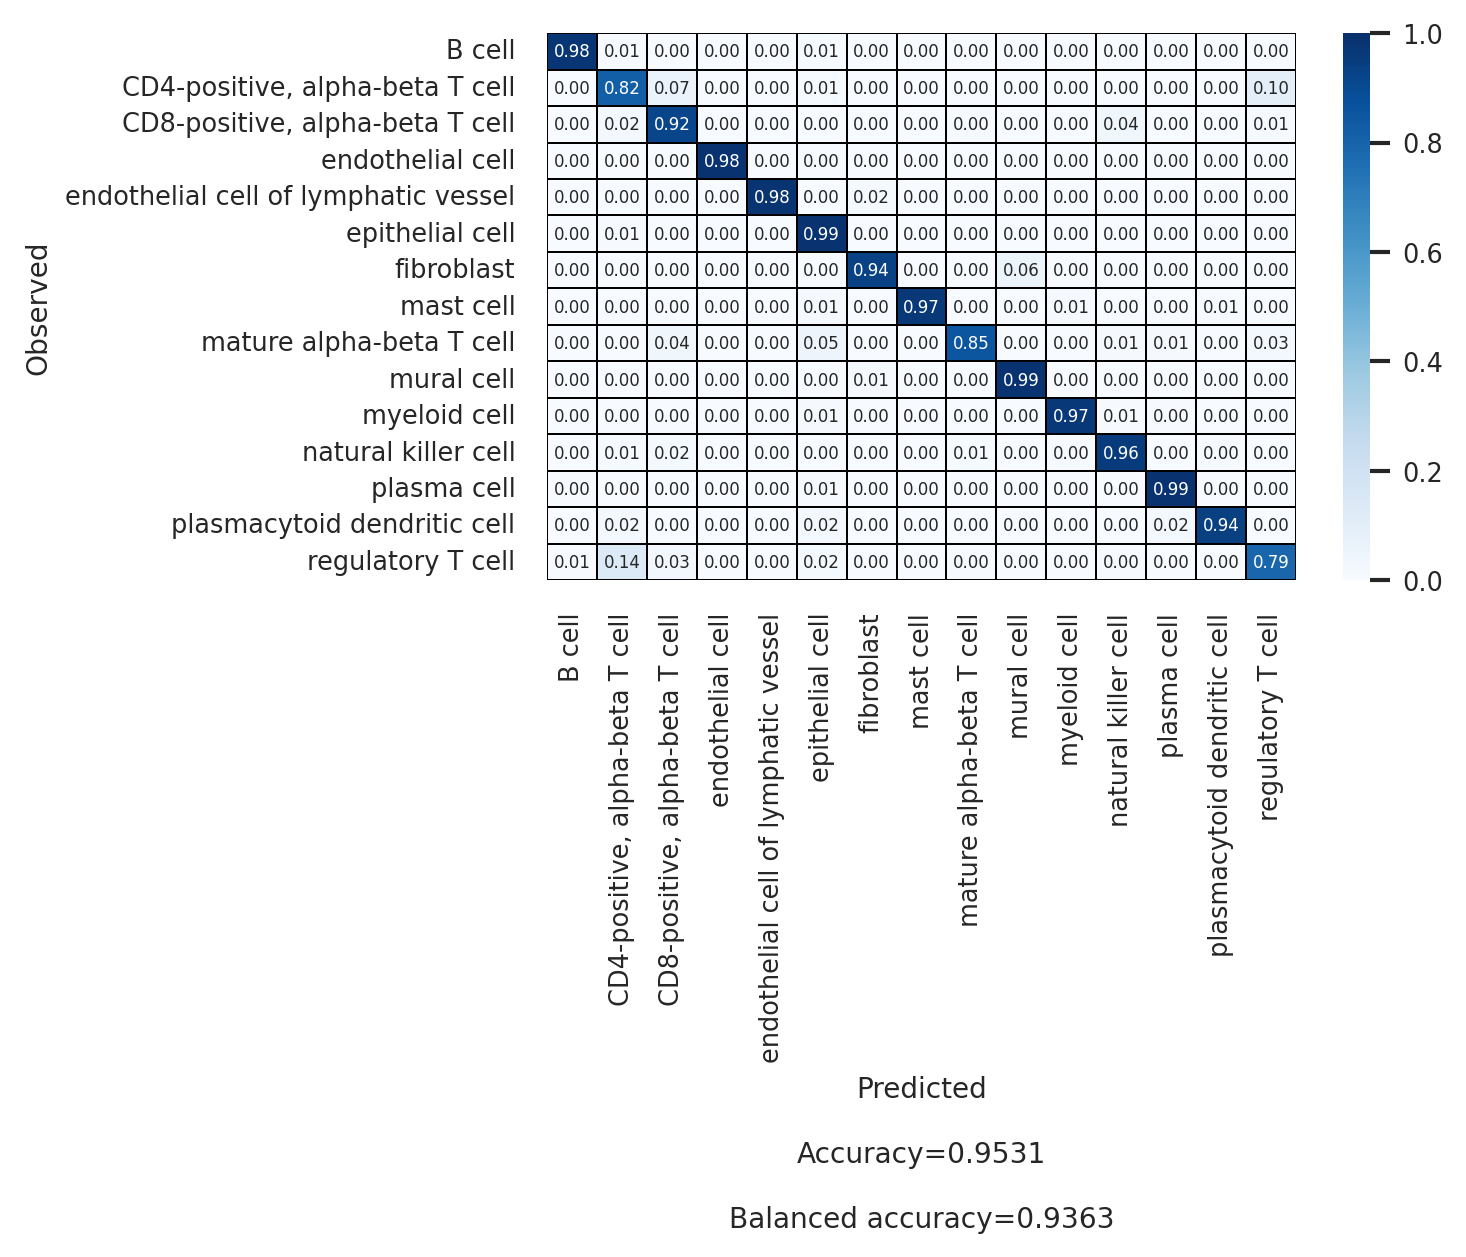

In [32]:
sns.set(font_scale = 0.7)
plt.figure(figsize = (5, 3))
scparadise.scnoah.conf_matrix(adata_test,
                              celltype = 'celltype_l2',
                              pred_celltype = 'pred_celltype_l2',
                              annot_kws = {"size":5},
                              linewidths = 0.1, linecolor = 'black',
                              fmt =  ".2f",
                              ndigits_metrics = 4,
                              vmin = 0, vmax = 1)

In [33]:
# Save anndata with predicted annotations
adata_test.write_h5ad('adata_test_imbalanced_model.h5ad')

In [34]:
import session_info
session_info.show()